In [151]:
import os

import numpy as np
import pandas as pd
import SimpleITK as sitk

LUNA_PATH = '/scr/nodules/luna16/train/'
LUNA_AUX_PATH = '/scr/nodules/luna16/CSVFILES/'

#Generate a spherical mask for a single nodule
#Can replace this with each radiologists' roi from lidc-idri
def getNoduleMask(shape, center, radius, origin):
  mask = np.zeros(shape)
  radius = np.rint(radius)
  center = np.round(np.array(center-origin)).astype(int)
  sz = np.arange(int(center[0]-radius),int(center[0]+radius+1))
  sy = np.arange(int(center[1]-radius),int(center[1]+radius+1))
  sx = np.arange(int(center[2]-radius),int(center[2]+radius+1))
  sz,sy,sx = np.meshgrid(sz,sy,sx)
  distance = ((center[0]-sz)**2 +(center[1]-sy)**2+(center[2]-sx)**2)
  distanceMatrix = np.ones_like(mask)*np.inf
  distanceMatrix[sx,sy,sz] = distance
  mask[distanceMatrix <= radius**2] = 1
  return mask

#Generates masks for all nodules in image
#Returns a single binary array
def getImageMask(shape, origin, annotations):
  mask = np.zeros(shape)
  for nodule in annotations:
    mask += getNoduleMask(shape,nodule[:3],nodule[3]/2.,origin)
  mask = np.clip(mask, 0, 1)
  return mask

In [186]:
import copy 
from glob import glob
import pandas as pd
SAMPLES_PATH = '/scr/nodules/luna16/val/subset0/'
SAMPLE_CANDIDATES_PATH = '/home/g/Desktop/git/nodules/resources/annotations.csv'
path = SAMPLES_PATH
filelist = glob(path+'/*.mhd')
filepathlist = copy.deepcopy(filelist)
templist = []
for f in filelist:
  f = f.split('/')
  f = f[-1]
  templist.append(f[:-4])
filelist = templist
no = 23
df = pd.read_csv(SAMPLE_CANDIDATES_PATH)
print df[df['seriesuid']==filelist[no]]
fname = filelist[no]

                                              seriesuid      coordX  \
1020  1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500...  113.911431   
1021  1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500...  -87.298239   
1022  1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500...  -42.906493   

         coordY      coordZ  diameter_mm  
1020 -36.972024 -139.106781     4.315291  
1021  56.271657 -112.290634     5.965580  
1022  -3.298740 -115.103859     5.090964  


In [34]:
import scipy.ndimage

In [144]:
itk = sitk.ReadImage(filepathlist[no])
image = sitk.GetArrayFromImage(itk)
copyimage = copy.deepcopy(image)

In [190]:
image = copy.deepcopy(copyimage)

In [158]:
origin = np.array(list(reversed(itk.GetOrigin())))
spacing = np.array(list(reversed(itk.GetSpacing())))
szfactor = spacing / [1,1,1]
newShape = image.shape * spacing
newShape = np.round(newShape)
szfactor = newShape / image.shape
image = scipy.ndimage.interpolation.zoom(image, szfactor, mode='nearest')

In [ ]:
shape = image.shape
annotations = df[df['seriesuid']==fname]
annotations = annotations[['coordX','coordY','coordZ','diameter_mm']].as_matrix()
origin = np.array(itk.GetOrigin())
mask = getImageMask(shape, origin, annotations)

In [107]:
print mask.shape
print image.shape

(286, 335, 335)
(286, 335, 335)


In [160]:
image[mask==0] = 0

In [49]:
import matplotlib.pyplot as plt

[276 131 162]


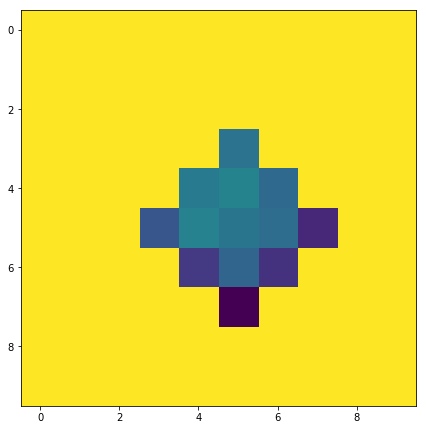

In [195]:
coords = annotations[0]
coords = coords[:-1]
coords = np.round(coords-origin).astype(int)
print coords
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(image[coords[2],coords[1]-5:coords[1]+5,coords[0]-5:coords[0]+5])
plt.show()